In [1]:
# import function
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [ ]:
# How may images we split
BATCH_SIZE = 128

# Default # of process
NUM_CLASSES = 10

# Use GPU to run 
DEVICE = "cuda:0"

In [ ]:
# resize images
# crop image
# transfer image pixel value to tensor
# normalize image data
train_transform = transforms.Compose([transforms.Resize((255, 255)),
                                      transforms.RandomCrop((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                      ])

test_transform = transforms.Compose([transforms.Resize((255, 255)),
                                     transforms.CenterCrop((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Laod training and testing dataset
train_dataset = datasets.CIFAR10(root='data', train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root='data', train=False, transform=test_transform, download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

Extracting data/cifar-10-python.tar.gz to data


In [ ]:
# TO check what knids of classes we have
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
Tclasses = test_dataset.classes
Tclasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# Define Alexnet architecture
# Conv2d output channel change, set up feature map size, step, and padding 
# ReLU: a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.
# Maxpool2D: extract how many image info we need
# self.fc set up fully-connected layer
# dropout:a regularization technique for reducing overfitting in artificial neural networks by preventing complex co-adaptations on training data.
# nn.linear: Applies a linear transformation to the incoming data: y = x*W^T + b

class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # modify input image size
            nn.AdaptiveAvgPool2d((6, 6))
        )
        self.FC = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)
        )
    #     self.init_bias()

    # def init_bias(self):
    #     for layer in self.features:
    #         if isinstance(layer, nn.Conv2d):
    #             nn.init.normal_(layer.weight, mean=0, std=0.01)
    #             nn.init.constant_(layer.bias, 0)
    #     # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
    #     nn.init.constant_(self.features[4].bias, 1)
    #     nn.init.constant_(self.features[10].bias, 1)
    #     nn.init.constant_(self.features[12].bias, 1)


  # forward to next layer
    def forward(self, x):
        out = self.features(x)
        out = out.view(x.size(0), 256 * 6 * 6)
        out = self.FC(out)

        # to normalize the output of a network to a probability distribution over predicted output classes
        probas = F.softmax(out, dim=1)
        return out, probas



In [ ]:
torch.manual_seed(1)
model = AlexNet()
model.to(DEVICE)


# use SGD optimizer to gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
cost, trainACC, validACC = [], [], []

In [ ]:
# compute training and testing accuracy
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
   
    # extract input image info and labels
    for i, data in enumerate(data_loader):
            
        inputs = data[0].to(device)
        labels = data[1].to(device)

        out, probas = model(inputs)
        x, predicted_labels = torch.max(probas, 1)
        num_examples += labels.size(0)

        # if label matches, add it to calculate accuracy
        if predicted_labels.size() == labels.size():
          correct_pred += (predicted_labels == labels).sum()
    return (correct_pred.float()/num_examples) * 100


In [ ]:
start_time = time.time()
NUM_EPOCHS = 50
for epoch in range(NUM_EPOCHS):
    for i, T_data in enumerate(train_loader):
        
        features = T_data[0].to(DEVICE)
        targets = T_data[1].to(DEVICE)

        optimizer.zero_grad()    
       
        out, probas = model(features)

        # Cross-entropy is a measure from the field of information theory, building upon entropy and generally calculating the difference between two probability distributions.
        loss = F.cross_entropy(out, targets)

        # computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x.
        loss.backward()
        optimizer.step()

        cost.append(loss.item())
        if not i % 500:
            print (f'Epoch: {epoch+1:03d}   '
                   f'Batch: {i:03d}/{len(train_loader):03d} ' 
                   f'Loss: {loss:.4f}')
            
        
    with torch.set_grad_enabled(False):
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        trainACC.append(train_acc)
        
        valid_acc = compute_acc(model, test_loader, device=DEVICE)
        validACC.append(valid_acc)
        
        # output accuracy
        print(f'Train ACC: {train_acc:.2f}\n'
              f'Validation ACC: {valid_acc:.2f}\n')     
  
T = (time.time() - start_time)/60
print(f'Total Training Time: {T:.2f} min')

Epoch: 001   Batch: 000/391 Loss: 2.3016
Train ACC: 11.45
Validation ACC: 11.32

Epoch: 002   Batch: 000/391 Loss: 2.3003
Train ACC: 16.72
Validation ACC: 17.09

Epoch: 003   Batch: 000/391 Loss: 2.2745
Train ACC: 27.31
Validation ACC: 28.92

Epoch: 004   Batch: 000/391 Loss: 2.1855
Train ACC: 34.08
Validation ACC: 35.59

Epoch: 005   Batch: 000/391 Loss: 1.7885
Train ACC: 39.14
Validation ACC: 39.27

Epoch: 006   Batch: 000/391 Loss: 1.6083
Train ACC: 41.52
Validation ACC: 42.60

Epoch: 007   Batch: 000/391 Loss: 1.6202
Train ACC: 46.58
Validation ACC: 46.53

Epoch: 008   Batch: 000/391 Loss: 1.4467
Train ACC: 48.49
Validation ACC: 48.67

Epoch: 009   Batch: 000/391 Loss: 1.4129
Train ACC: 51.28
Validation ACC: 51.25

Epoch: 010   Batch: 000/391 Loss: 1.3460
Train ACC: 53.27
Validation ACC: 54.39

Epoch: 011   Batch: 000/391 Loss: 1.3172
Train ACC: 55.20
Validation ACC: 56.00

Epoch: 012   Batch: 000/391 Loss: 1.1453
Train ACC: 58.54
Validation ACC: 59.05

Epoch: 013   Batch: 000/391 

In [ ]:
print(len(cost))

19550


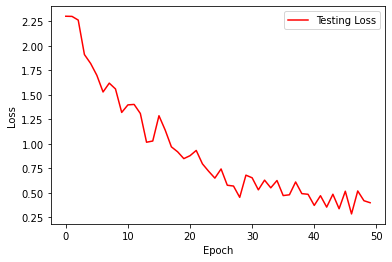

In [ ]:
# vizualize Loss vs Epoch of testing loss

import matplotlib.pyplot as plt
cost_tune = []
i = 0
while i < 19500:
  cost_tune.append(cost[i])
  i += 390
# print(len(cost))
x_value = list(range(50))
y_vaule = cost_tune



plt.plot(x_value, y_vaule, c='red', label='Testing Loss' )
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

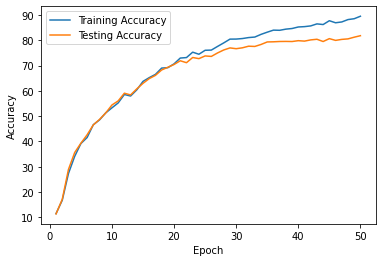

In [ ]:

# vizualize accuracy vs Epoch of training and testing loss

plt.plot(np.arange(1, NUM_EPOCHS+1), trainACC, label='Training Accuracy')
plt.plot(np.arange(1, NUM_EPOCHS+1), validACC, label='Testing Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()